In [1]:
#!pip install biopython
import sys, os, copy, pprint, glob
#import pathlib
from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pyfastx

In [2]:
sys.path.append('/home/ubuntu/git/Genotyper/src/')
import utils.BitOperations as B

## Import UniProt:  
Download One protein per gene
https://www.uniprot.org/proteomes/UP000005640

In [3]:
huprot_path="/tdata2/human_proteome/UP000005640_9606.fasta"
fa = pyfastx.Fasta(huprot_path)
fa

<Fasta> /tdata2/human_proteome/UP000005640_9606.fasta contains 20605 sequences

## N-mer Generation/Characterization:                         

In [4]:
reload(B)
B.DEBUG=True
class BitMap:
    """Stores chosen probes and provides universal indexing for peptides mapping to protein bitfields"""
    def __init__(self):
        self.d={}
        self.n=0
        self.LOCK=False
    def process_peptide(self, peptide):
        for p in peptide.Lst:
            if not(p in self.d):self.d[p]=0
            self.d[p]+=1
    def all_peptide_counts(self):
        return list(self.d.items())
    def order(self, count_limit=None):
        if self.LOCK:
            print('BitMap Has been Locked')
            return None
        lst=list(self.d.items())
        lst.sort(key=lambda x:-x[1])
        self.Lst=[]
        for i in range(len(lst)):
            p,n=lst[i]
            if count_limit and n<count_limit:break
            self.Lst.append(p)
        self.n=len(self.Lst)
        self.LOCK=True
    def write_token_to_bitfield(self, p, bitfield):
        #bitfield[self.Lst.index(p)]
        if not(p in self.Lst):return -1
        try:
            x= self.Lst.index(p)
            bitfield[self.Lst.index(p)]=1
        except:
            print('BFOverLimit:self.Lst.index(%s) bitfield sz: %i, idx: %i'%(p, bitfield.max, self.Lst.index(p)))
            return self.n
    def display(self, limit=500):
        print('BitMap: %i '%len(self.Lst))
        for i in range(min(limit, self.n)):
            p=self.Lst[i]
            print('%s\t%i'%(p, self.d[p]))
            
class Peptide:
    def __init__(self, seq, label, nmer_sz=6):
        self.nmer_sz=nmer_sz
        self.seq=seq
        self.label=label
        self.acc=label.split('|')[1]
        self.Lst=[]
        self.bf=None
        self.nmer_tile()
    def nmer_tile(self, nmer_sz=None):
        nmer_sz= self.nmer_sz if (nmer_sz==None) else nmer_sz
        for i in range(0,len(self.seq)-nmer_sz,1):
            self.Lst.append(self.seq[i:i+nmer_sz])
        self.Lst.sort()
    def make_bitfield(self, bit_map):
        self.bf=B.BitArray(bit_map.n+1)
        for p in self.Lst:
            bit_map.write_token_to_bitfield(p, self.bf)
    def display(self):
        print('acc: %s seq_len: %i, bf_occupancy: %i'%(self.acc, len(self.seq), self.bf.count()))
    

In [25]:
len(bitmap.d)

8050

In [5]:
huprot_path="/tdata2/human_proteome/UP000005640_9606.fasta"
fa_file = pyfastx.Fasta(huprot_path)
print(fa_file)
NMER_SZ=3


bitmap=BitMap()
pLst=[]
max_r=10000;i=0
for seq in fa_file:
    if len(seq.seq)<100:continue
    i+=1
    name=seq.name;
    prefix, acc=name.split('|')[0:2]
    if prefix=='tr':continue
    pLst.append(Peptide(seq.seq, name, nmer_sz=NMER_SZ))
    bitmap.process_peptide(pLst[-1])
    if i >max_r:break
all_peptide_counts=[p[1] for p in list(bitmap.d.items())]

bitmap.order(count_limit=2000)
bitmap.display()

<Fasta> /tdata2/human_proteome/UP000005640_9606.fasta contains 20605 sequences
BitMap: 1692 
SSS	8116
LLL	7813
EEE	7472
AAA	6713
PPP	6490
GGG	4765
SSL	4697
SLL	4633
LLS	4564
LEE	4515
LLA	4487
ALL	4486
EEL	4288
LSS	4170
PGP	4144
LLE	4066
SLS	4019
LSL	4017
LAL	3954
ELL	3908
LLG	3880
SSP	3862
PPG	3837
LAA	3798
AAL	3758
LGL	3757
SSG	3643
GSS	3638
SPS	3602
LPP	3588
GLL	3543
SGS	3531
PSS	3530
PSP	3510
VLL	3505
ASS	3496
PAP	3472
RLL	3463
LLR	3433
LLP	3404
GPP	3364
EAL	3318
ELE	3316
LLQ	3315
ALA	3302
GSG	3299
GEK	3297
PPA	3257
LEK	3225
LAS	3219
EEA	3218
PLP	3210
SSA	3207
PLL	3180
LEL	3179
AAG	3177
LSP	3174
LLV	3155
LKE	3152
LPG	3142
EEK	3141
LVL	3140
LLK	3126
ASL	3123
SLP	3115
SAS	3114
SLE	3108
LLD	3101
EKL	3098
QLL	3089
AAS	3072
PPS	3061
SAL	3029
LPS	3020
EKE	3020
SLA	3008
TSS	3001
LEA	3000
GPG	2988
LQE	2983
SEE	2973
PAA	2970
LPL	2964
SLG	2940
ALS	2937
PGS	2933
GSL	2925
GGS	2911
KKK	2908
GLP	2904
LLT	2899
SST	2899
SSE	2894
SPG	2886
KLL	2885
KEE	2884
TLL	2884
ALE	2878
LRL	2870
VSS	2854
TGE	285

In [11]:
bitmap.LOCK=False
bitmap.order(count_limit=2000)
bitmap.display()

BitMap: 339 
SSS	8116
LLL	7813
EEE	7472
AAA	6713
PPP	6490
GGG	4765
SSL	4697
SLL	4633
LLS	4564
LEE	4515
LLA	4487
ALL	4486
EEL	4288
LSS	4170
PGP	4144
LLE	4066
SLS	4019
LSL	4017
LAL	3954
ELL	3908
LLG	3880
SSP	3862
PPG	3837
LAA	3798
AAL	3758
LGL	3757
SSG	3643
GSS	3638
SPS	3602
LPP	3588
GLL	3543
SGS	3531
PSS	3530
PSP	3510
VLL	3505
ASS	3496
PAP	3472
RLL	3463
LLR	3433
LLP	3404
GPP	3364
EAL	3318
ELE	3316
LLQ	3315
ALA	3302
GSG	3299
GEK	3297
PPA	3257
LEK	3225
LAS	3219
EEA	3218
PLP	3210
SSA	3207
PLL	3180
LEL	3179
AAG	3177
LSP	3174
LLV	3155
LKE	3152
LPG	3142
EEK	3141
LVL	3140
LLK	3126
ASL	3123
SLP	3115
SAS	3114
SLE	3108
LLD	3101
EKL	3098
QLL	3089
AAS	3072
PPS	3061
SAL	3029
LPS	3020
EKE	3020
SLA	3008
TSS	3001
LEA	3000
GPG	2988
LQE	2983
SEE	2973
PAA	2970
LPL	2964
SLG	2940
ALS	2937
PGS	2933
GSL	2925
GGS	2911
KKK	2908
GLP	2904
LLT	2899
SST	2899
SSE	2894
SPG	2886
KLL	2885
KEE	2884
TLL	2884
ALE	2878
LRL	2870
VSS	2854
TGE	2853
LGS	2847
PGL	2841
ALG	2839
SGG	2839
EAE	2834
LSA	2827
DLL	2826
EED	2823
SPA	28

8050


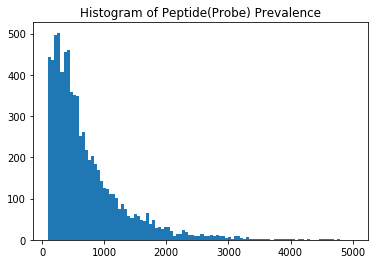

In [12]:
fig, axs = plt.subplots(tight_layout=False)
# We can set the number of bins with the `bins` kwarg
plt.title("Histogram of Peptide(Probe) Prevalence")
yo=axs.hist(all_peptide_counts, bins=100, range=(100,5000))
print(len(all_peptide_counts))

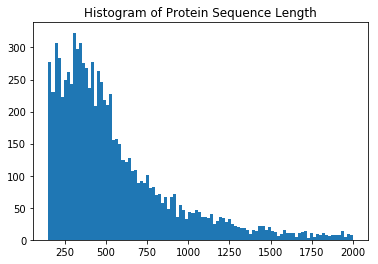

In [13]:
fig, axs = plt.subplots(tight_layout=False)

# We can set the number of bins with the `bins` kwarg
plt.title("Histogram of Protein Sequence Length")
yo=axs.hist([len(p.seq) for p in pLst], bins=100, range=(150,2000))

In [14]:
#select proteins by size
protLst=[]
for p in pLst:
    if 100<len(p.seq)<800:
        p.make_bitfield(bitmap)
        protLst.append(p)
        if random.random()<0.001:p.display()
print(len(protLst))

acc: O75343 seq_len: 617, bf_occupancy: 62
acc: P60660 seq_len: 151, bf_occupancy: 14
acc: Q14314 seq_len: 439, bf_occupancy: 47
acc: Q14746 seq_len: 738, bf_occupancy: 114
acc: Q14938 seq_len: 502, bf_occupancy: 68
acc: Q494X3 seq_len: 552, bf_occupancy: 34
acc: Q6A555 seq_len: 127, bf_occupancy: 13
7973


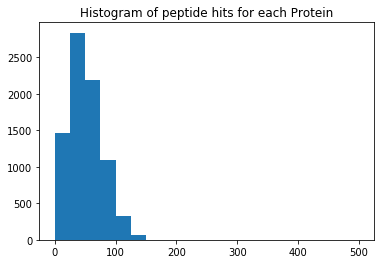

In [15]:
fig, axs = plt.subplots(tight_layout=False)

# We can set the number of bins with the `bins` kwarg
plt.title("Histogram of peptide hits for each Protein")
yo=axs.hist([p.bf.count() for p in protLst], bins=20, range=(0,500))

In [16]:
iLst=[];plotLst=[]
protLst.sort(key=lambda x:-x.bf.count())
for p in protLst:
    row=[int(x) for x in list(p.bf.bin_str())]
    if random.random()<0.001:print(p.label, p.bf.array_sz, p.bf.max, len(row), p.bf.count(), len(p.bf.export_bit_idxLst()))
    iLst.append([p.label] + row)
    plotLst.append(row)
bf_img=np.array(iLst)
print(len(iLst))
img = Image.fromarray(bf_img, mode='1')
img.save('bf_img.jpg', format='JPEG', subsampling=0, quality=100)
LL=[N for N in bitmap.Lst]
extra_spacers=len(row)-len(LL)
LL=['seq_name']+LL+list(range(extra_spacers))
df = pd.DataFrame(iLst, columns=LL)
df.to_csv('hitmap.csv')

sp|O15240|VGF_HUMAN 6 340 384 125 125
sp|Q14694|UBP10_HUMAN 6 340 384 97 97
sp|Q64LD2|WDR25_HUMAN 6 340 384 60 60
sp|P07947|YES_HUMAN 6 340 384 52 52
sp|P28347|TEAD1_HUMAN 6 340 384 51 51
sp|B5MCN3|S14L6_HUMAN 6 340 384 47 47
sp|O75897|ST1C4_HUMAN 6 340 384 28 28
sp|P01036|CYTS_HUMAN 6 340 384 20 20
sp|Q15940|ZNF67_HUMAN 6 340 384 17 17
7973


[Text(30.5,0.5,'Protein_subset'), Text(0.5,12.5,'Peptide n-mers')]

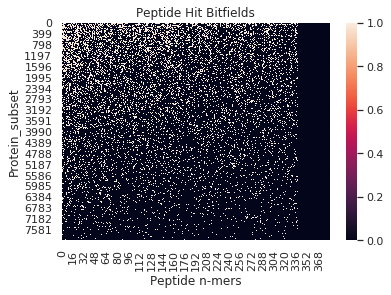

In [17]:
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)

plt.show()
ax = sns.heatmap([p[:] for p in plotLst])
plt.title("Peptide Hit Bitfields")
ax.set(xlabel='Peptide n-mers', ylabel='Protein_subset')

[Text(30.5,0.5,'Protein_idx'), Text(0.5,12.5,'Protein_idx')]

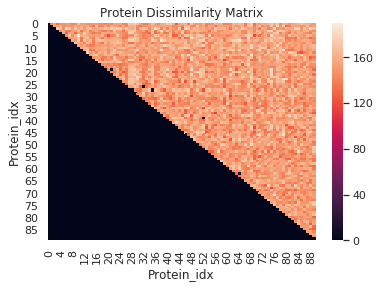

In [18]:
#dissimilarityMatrix
NumSeqs=90;pairLst=[]
DM=[[0 for x in range(NumSeqs)] for x in range(NumSeqs)]
for i in range(NumSeqs):
    a=protLst[i]
    for j in range(i, NumSeqs, 1):
        b=protLst[j]
        d=(a.bf)^(b.bf)
        DM[i][j]=d.count()
        pairLst.append([i,j,DM[i][j]])
pairLst.sort(key=lambda x:x[-1])
plt.show()
ax = sns.heatmap(DM)
plt.title("Protein Dissimilarity Matrix")
ax.set(xlabel='Protein_idx', ylabel='Protein_idx') 

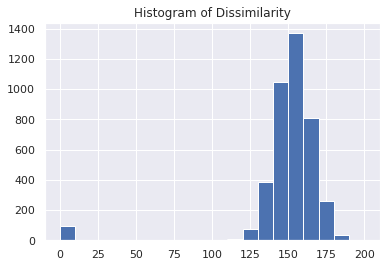

In [19]:
fig, axs = plt.subplots(tight_layout=False)
plt.title("Histogram of Dissimilarity")
yo=axs.hist([p[-1] for p in pairLst], bins=20, range=(0,200))

## Probe Choice

In [20]:
import multiprocessing as mp
from contextlib import closing
 
def chooseMostPrevalentProbe(probeLst, probe_bitmap, randomize=True):
    number_Lst=[probe_bitmap.d[probe] for probe in probeLst]
    if randomize:
        n_sum=sum(number_Lst)
        r=int(random.random()*n_sum)
        for i in range(len(number_Lst)):
            r-=number_Lst[i]
            if r<0:break
        return probeLst[i]
    else:
        return probeLst[np.argmax(number_Lst)]
    
    
def GenerateProbeSetBF(probeLst, probe_bitmap):
    probeset_bf=B.BitArray(probe_bitmap.n+1)
    for probe in probeLst:
        probe_idx=probe_bitmap.Lst.index(probe)
        probeset_bf[probe_idx]=1
    return probeset_bf

def ComputeProteinClusters(proteinLst, probeset_bf):
    """This function computes the number of clusters 
    given a set of proteins and choice of probes"""
    proteinprobehit_bfLst=[]
    dedup_dict={}
    for protein in proteinLst:
        pap=protein.bf&probeset_bf
        bstr=pap.bin_str()
        if not bstr in dedup_dict:dedup_dict[bstr]=0
        dedup_dict[bstr]+=1
        proteinprobehit_bfLst.append(pap)
    return dedup_dict, proteinprobehit_bfLst

def ChoiceCycle(proteinLst, probe_bitmap, probeLst, choice_window=0):
    probeset_bf=GenerateProbeSetBF(probeLst, probe_bitmap)
    probe_choiceLst=[]
    for probe in probe_bitmap.Lst:
        if (probe in probeLst):continue
        probe_idx=probe_bitmap.Lst.index(probe)
        if probeset_bf[probe_idx]:continue
        probeset_bf[probe_idx]=1
        dedupe_dict, proteinprobehit_bfLst= ComputeProteinClusters(proteinLst, probeset_bf)
        probe_choiceLst.append([len(dedupe_dict), probe])
        probeset_bf[probe_idx]=0
    probe_choiceLst.sort(key=lambda x:-x[0])
    top_num_clusters=probe_choiceLst[0][0]
    choiceLst=[]
    for i in range(len(probe_choiceLst)):
        c=probe_choiceLst[i]
        if top_num_clusters-c[0]>=choice_window:
            choiceLst.append(c)
        else:
            break
    print('ChoiceCycle:probe_choiceLst:%i choiceLst:%i top_num_clusters:%i'%(len(probe_choiceLst),len(choiceLst), top_num_clusters))
    #print(choiceLst)
    return choiceLst

def compute_protein_clusters_Runner(t):
    proteinLst, probeset_bf, probe_idx, probe = t
    probeset_bf[probe_idx]=1
    dedupe_dict, proteinprobehit_bfLst= ComputeProteinClusters(proteinLst, probeset_bf)
    return [len(dedupe_dict), probe]
    
def ChoiceCycle_mp(proteinLst, probe_bitmap, probeLst, choice_window=0, num_ranks=24):
    probeset_bf=GenerateProbeSetBF(probeLst, probe_bitmap)
    probe_choiceLst=[]
    processingLst=[]
    for probe in probe_bitmap.Lst:
        if (probe in probeLst):continue
        probe_idx=probe_bitmap.Lst.index(probe)
        if probeset_bf[probe_idx]:continue
        processingLst.append([proteinLst, probeset_bf.copy(), probe_idx, probe])
    with closing( mp.Pool(num_ranks) ) as p:
        probe_choiceLst=p.map(compute_protein_clusters_Runner, processingLst)
    probe_choiceLst.sort(key=lambda x:-x[0])
    top_num_clusters=probe_choiceLst[0][0]
    choiceLst=[]
    for i in range(len(probe_choiceLst)):
        c=probe_choiceLst[i]
        if top_num_clusters-c[0]>=choice_window:
            choiceLst.append(c)
        else:
            break
    print('ChoiceCycle:probe_choiceLst:%i choiceLst:%i top_num_clusters:%i'%(len(probe_choiceLst),len(choiceLst), top_num_clusters))
    #print(choiceLst)
    return choiceLst

In [ ]:
probe_bitmap=bitmap
RND_CHOICE=False
probeLst=[chooseMostPrevalentProbe(probe_bitmap.Lst, probe_bitmap, randomize=RND_CHOICE)]
cycleLst=[];cycleLL=['cycle', 'num_clusters', 'num_choice_possibilities', 'probeSet']
discernible_clusters=0;clusters_to_discern=len(protLst)
cycle=0;previous_discernible_clusters=0
while discernible_clusters < clusters_to_discern:
    cycle+=1
    choiceLst=ChoiceCycle_mp(protLst, bitmap, probeLst, choice_window=0, num_ranks=12)
    prLst=[c[1] for c in choiceLst]
    probe=chooseMostPrevalentProbe(prLst, probe_bitmap, randomize=RND_CHOICE)
    choice_idx=prLst.index(probe)
    #Choose first of equals You can also choose randomly or choose from within choice_window range
    num_clusters,probe =choiceLst[choice_idx]
    if num_clusters>discernible_clusters:
        probeLst.append(probe)
        cycleLst.append([cycle, num_clusters, len(choiceLst), '|'.join(probeLst)])
        discernible_clusters=num_clusters
        print(cycle, num_clusters, len(choiceLst), probe)
    else:
        print('No more optimization is possible')
        break
    
print(probeLst)

ChoiceCycle:probe_choiceLst:338 choiceLst:338 top_num_clusters:4
1 4 338 LLL
ChoiceCycle:probe_choiceLst:337 choiceLst:337 top_num_clusters:8
2 8 337 EEE
ChoiceCycle:probe_choiceLst:336 choiceLst:336 top_num_clusters:16
3 16 336 AAA
ChoiceCycle:probe_choiceLst:335 choiceLst:335 top_num_clusters:32
4 32 335 PPP
ChoiceCycle:probe_choiceLst:334 choiceLst:334 top_num_clusters:64
5 64 334 GGG
ChoiceCycle:probe_choiceLst:333 choiceLst:333 top_num_clusters:128
6 128 333 SSL
ChoiceCycle:probe_choiceLst:332 choiceLst:332 top_num_clusters:254
7 250 332 SLL
ChoiceCycle:probe_choiceLst:331 choiceLst:331 top_num_clusters:470
8 467 331 LLS
ChoiceCycle:probe_choiceLst:330 choiceLst:330 top_num_clusters:795
9 766 330 LEE
ChoiceCycle:probe_choiceLst:329 choiceLst:329 top_num_clusters:1197
10 1183 329 LLA
ChoiceCycle:probe_choiceLst:328 choiceLst:328 top_num_clusters:1696
11 1683 328 ALL
ChoiceCycle:probe_choiceLst:327 choiceLst:327 top_num_clusters:2243
12 2196 327 EEL
ChoiceCycle:probe_choiceLst:326 c

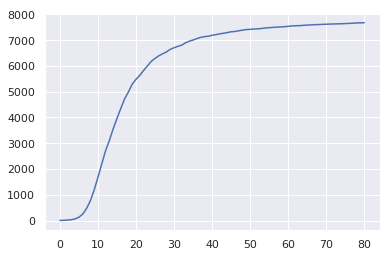

In [23]:
ud="/tdata2/human_proteome/"
clst=[[r[0], r[1], len(r[3].split('|'))] for r in cycleLst]
df=pd.DataFrame(clst, columns=['cycle',
                                'num_clusters', 
                                'num_probes'])
df.to_csv(ud+'cycle_run_n6472.csv')

plt.plot(list(range(len(clst))), [c[1] for c in clst])
plt.show()

In [ ]:
probeLst
probeset_bf=GenerateProbeSetBF(probeLst, bitmap)
probeset_bf.count(), len(probeLst), probeset_bf.bin_str()

## Protein Digestion:  

https://pyopenms.readthedocs.io/en/latest/installation.html  

https://readthedocs.org/projects/pyopenms/downloads/pdf/release_2.4.0/

In [ ]:
from pyopenms import *


p=ProteaseDB()
n=[]
p.getAllNames(n)
n

def digest(enz, fa_file, rngLst=[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000]):
    dig.setEnzyme(enz)
    size_dict={}
    fa = pyfastx.Fasta(huprot_path)
    oLst=[]
    for seq in fa_file:
        result = []
        s=seq.seq;name=seq.name;
        prefix, acc=name.split('|')[0:2]
        if prefix=='tr':continue
        dig.digest(AASequence.fromString(s), result)
        result=[r.toString() for r in result]
        print(name, len(result), end='\r')
        for i in range(len(rngLst)-1):
            min_sz=rngLst[i];max_sz=rngLst[i+1]
            mami='%i_%i'%(min_sz, max_sz)
            if not(mami in size_dict):size_dict[mami]={}
            l=list(filter(lambda x:min_sz<=len(x)<max_sz, result))
            if l:
                size_dict[mami][acc]=l
    return size_dict

In [ ]:
huprot_path="/tdata2/human_proteome/UP000005640_9606.fasta"

dig = ProteaseDigestion()
oLst=[];LL=['enz', 'size_range', 'num_proteins', 'avg_frags', 'stdev_frags']

enz_names=[
    b'Trypsin',
         b'Clostripain/P',
         b'Glu-C+P',
         b'TrypChymo',
         b'Arg-C/P',
         b'V8-E',
         b'Chymotrypsin',
         b'elastase-trypsin-chymotrypsin',
         b'staphylococcal protease/D',
         b'Trypsin/P',
         #b'unspecific cleavage',
         b'Chymotrypsin/P',
         b'proline-endopeptidase/HKR',
         b'PepsinA + P',
         b'cyanogen-bromide',
         #b'CNBr',
         b'V8-DE',
         b'Lys-C/P',
         b'leukocyte elastase',
         b'proline endopeptidase',
         b'glutamyl endopeptidase',
         b'Alpha-lytic protease',
         b'2-iodobenzoate',
         b'iodosobenzoate',
         b'Arg-C',
         b'Asp-N/B',
         b'Lys-C',
         b'PepsinA',
         b'Asp-N_ambic',
         b'Lys-N',
         b'Formic_acid',
         b'Asp-N',
         #b'no cleavage'
          ]

enz_names=[
    b'Asp-N/B',b'CNBr',
]
#p.getAllNames(enz_names)
rngLst=[50, 200]#[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000])
for enz in enz_names:
    print(enz)
    dig.setEnzyme(enz)
    size_dict=digest(enz, fa, rngLst=rngLst)
    for i in range(len(rngLst)-1):
        min_sz=rngLst[i];max_sz=rngLst[i+1]
        mami='%i_%i'%(min_sz, max_sz)
        clst = np.array([len(size_dict[mami][k]) for k in size_dict[mami].keys()])
        oLst.append([enz, mami, len(size_dict[mami]), clst.mean(), clst.std()])
df = pd.DataFrame(oLst, columns=LL)
enz_str=str(enz).replace(' ','').replace('/', '-').replace('+','plus').replace("'", '')[1:]
df.to_csv('all_digestions50-200.csv')
df

In [ ]:
import seaborn as sns

fragLst=[]
for k in size_dict[mami].keys():
    fragLst.extend([len(x) for x in size_dict[mami][k]])
sns.set(style="whitegrid")

ax = sns.violinplot(x=fragLst)